In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/Users/sainadh/Desktop/emotion/Crema'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/Users/sainadh/Desktop/emotion/Crema/1022_ITS_ANG_XX.wav
/Users/sainadh/Desktop/emotion/Crema/1037_ITS_ANG_XX.wav
/Users/sainadh/Desktop/emotion/Crema/1060_ITS_NEU_XX.wav
/Users/sainadh/Desktop/emotion/Crema/1075_ITS_NEU_XX.wav
/Users/sainadh/Desktop/emotion/Crema/1073_IOM_DIS_XX.wav
/Users/sainadh/Desktop/emotion/Crema/1066_IOM_DIS_XX.wav
/Users/sainadh/Desktop/emotion/Crema/1078_IWL_SAD_XX.wav
/Users/sainadh/Desktop/emotion/Crema/1029_TAI_FEA_XX.wav
/Users/sainadh/Desktop/emotion/Crema/1039_IEO_SAD_MD.wav
/Users/sainadh/Desktop/emotion/Crema/1008_TAI_HAP_XX.wav
/Users/sainadh/Desktop/emotion/Crema/1018_TSI_FEA_XX.wav
/Users/sainadh/Desktop/emotion/Crema/1028_IEO_SAD_HI.wav
/Users/sainadh/Desktop/emotion/Crema/1039_TSI_HAP_XX.wav
/Users/sainadh/Desktop/emotion/Crema/1064_ITS_HAP_XX.wav
/Users/sainadh/Desktop/emotion/Crema/1071_ITS_HAP_XX.wav
/Users/sainadh/Desktop/emotion/Crema/1045_ITS_FEA_XX.wav
/Users/sainadh/Desktop/emotion/Crema/1050_ITS_FEA_XX.wav
/Users/sainadh/Desktop/emotion/

In [47]:
#Source 
# https://learnpython.com/blog/plot-waveform-in-python/

In [48]:
#Wave is the library to read and write audio files
import wave

wav_obj = wave.open('/Users/sainadh/Desktop/emotion/Crema/1060_ITS_NEU_XX.wav','rb')
sample_freq = wav_obj.getframerate()
# number of frames per second
print(sample_freq)

16000


In [49]:
#Getting the number of frames in the audio file
n_samples = wav_obj.getnframes()
# number of frames
print(n_samples)


38438


In [50]:

t_audio = n_samples/sample_freq
# duration of audio clip in seconds
print(t_audio)

2.402375


In [51]:
# finding number of channels
n_channels = wav_obj.getnchannels()
print(n_channels)

1


In [52]:
#gathering signals from the audio file
wave_signal = wav_obj.readframes(n_samples)

In [53]:
#array of frame data from audio
signals = np.frombuffer(wave_signal, dtype=np.int16)

In [54]:
#printing the signals shape
print(signals.shape)

(38438,)


In [55]:
#linearly spaced values 
times = np.linspace(0, n_samples/sample_freq, num=n_samples)

In [56]:
import matplotlib.pyplot as plt

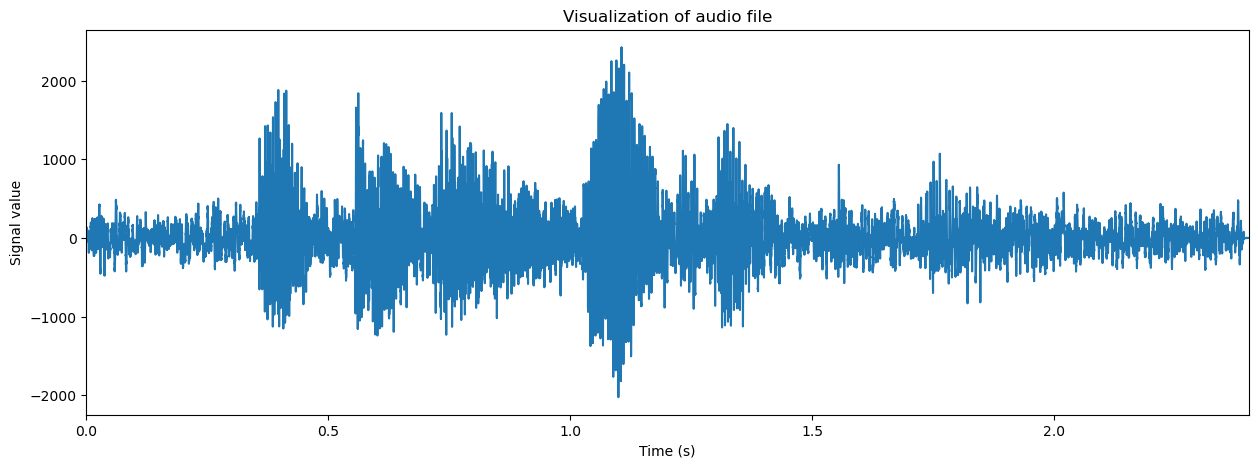

In [57]:
#Visualisation of the audio file
plt.figure(figsize=(15,5))
plt.plot(times,signals)
plt.title('Visualization of audio file')
plt.xlabel('Time (s)')
plt.ylabel('Signal value')
plt.xlim(0,t_audio)
plt.show()

In [58]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [59]:
# Load an audio file
audio_file = "/Users/sainadh/Desktop/emotion/Crema/1060_ITS_NEU_XX.wav"
y, sr = librosa.load(audio_file)

In [60]:
# Calculate MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # You can specify the number of MFCCs (e.g., n_mfcc=13)

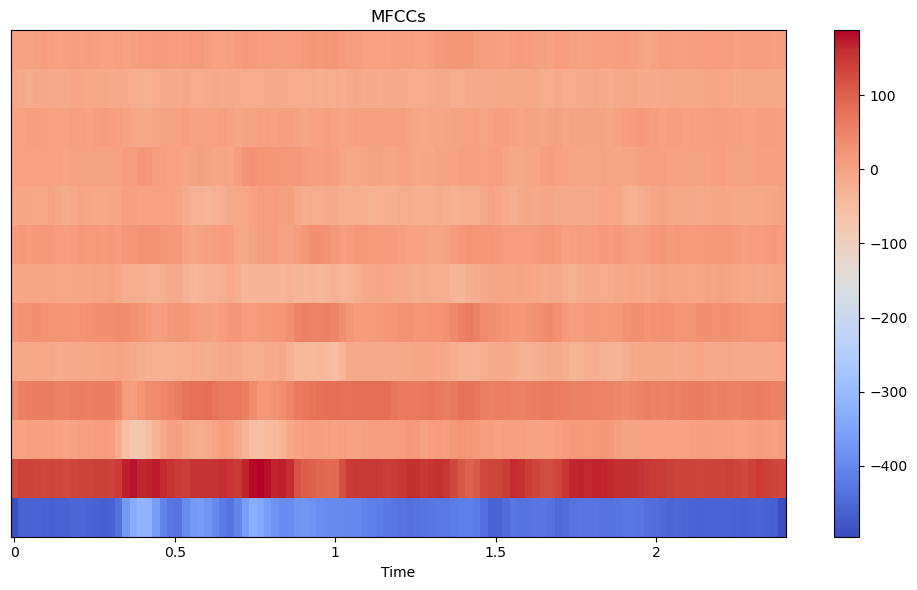

In [61]:
# Plot MFCCs
plt.figure(figsize=(10, 6))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCCs')
plt.tight_layout()
plt.show()


In [63]:
# Select a specific frame (e.g., frame 10)
frame_index = 10
frame_mfccs = mfccs[:, frame_index]


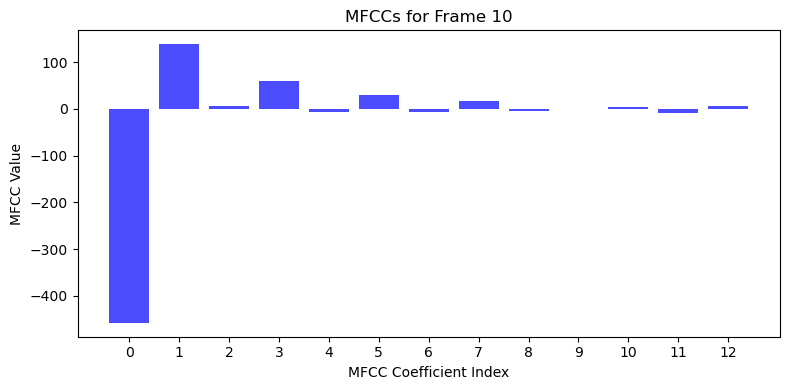

In [65]:
# Create a bar graph for the selected frame
plt.figure(figsize=(8, 4))
plt.bar(range(len(frame_mfccs)), frame_mfccs, color='b', alpha=0.7)
plt.xlabel('MFCC Coefficient Index')
plt.ylabel('MFCC Value')
plt.title(f'MFCCs for Frame {frame_index}')
plt.xticks(range(len(frame_mfccs)))  # Label the x-axis with coefficient indices
plt.tight_layout()
plt.show()